* For selecting a hold out set, I always try to imitate the way that the train and test set were split. So, if it is a time split, I split my holdout sample time based; if it is a geographical split by city, I split my holdout set by city; and if it is a random split, then my holdout split will be random as well. 

*  calculation of averages over different time windows. For each day in the sales history, I calculated averages over the last quarter, last half year, last year and last 2 years. Those averages were split out by important features like day of week and promotions. Second, some time indicators were important: not only month and day of year, but also relative indicators like number of days since the summer holidays started. Like most teams, I used extreme gradient boosting (xgboost) as a learning method.

* Remove dates where store is closed? Look at test data

* Join table. Indicate promo2 on data

* Add week of year.. for Christmas holidays eg

* Break down year and month for analysis

* Box plot for week of year, day of week..

* GLM poisson

* Recent Data -- Extract Features on last quarter, last 0.5 year, 1 year and 2 years , Median / Mean / Harmonic Mean , SD / Skewness / Kurtosis

* Temporal Information - day counter indicates either the number of days before, after or within the event (promotion cycle 14 days, secondary promotion every 3 months , summer holidays, store refurbishments, start of competition, start of secondary promotion cycle) 

In [ ]:
# %store dt_features
# %store -r encoder

In [1]:
import pandas as pd
import numpy as np
import datetime

import pickle
from pivottablejs import pivot_ui
from scipy.optimize import (minimize,basinhopping)
from scipy.stats import uniform as sp_rand

from sklearn import (metrics, cross_validation, linear_model, preprocessing)
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import (GradientBoostingClassifier,RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split

import seaborn as sb
import matplotlib.pyplot as plt  
%matplotlib inline

In [92]:
dstore = pd.read_csv('store.csv',dtype={'Store':int})
dtrain = pd.read_csv('train.csv',
                     parse_dates=['Date'],
                     date_parser=(lambda dt:pd.to_datetime(dt,format='%Y-%m-%d')),
                     dtype={'Store':int,'DayOfWeek':int,'Sales':int,'Customers':int,'Open':int,'Promo':int,'SchoolHoliday':int})
holiday_columns = ['0','a','b','c']
dtrain['StateHoliday'] = pd.Categorical(dtrain.StateHoliday, categories=holiday_columns)
# dtrain.info()
dtest = pd.read_csv('test.csv',
                    dtype={'Id':int,'Store':int,'DayOfWeek':int,'Promo':int,'SchoolHoliday':int},
                    parse_dates=['Date'],
                    date_parser=(lambda dt:pd.to_datetime(dt,format='%Y-%m-%d')))
dtest['Open'].fillna(0,inplace=True)
dtest['Open'] = dtest['Open'].astype(int)
# dtest = pd.read_csv('test.csv')
dtest['StateHoliday'] = pd.Categorical(dtest.StateHoliday, categories=holiday_columns)


In [173]:
dtrain.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31 08:00:00,5263,555,1,1,0,1
1,2,5,2015-07-31 08:00:00,6064,625,1,1,0,1
2,3,5,2015-07-31 08:00:00,8314,821,1,1,0,1
3,4,5,2015-07-31 08:00:00,13995,1498,1,1,0,1
4,5,5,2015-07-31 08:00:00,4822,559,1,1,0,1


In [136]:
# Data Exploration 

print("Start Date %s and End Date %s in train dataset" % (dtrain['Date'].min().strftime('%Y-%m-%d'),dtrain['Date'].max().strftime('%Y-%m-%d')))
print("Start Date %s and End Date %s in test dataset" % (dtest['Date'].min().strftime('%Y-%m-%d'),dtest['Date'].max().strftime('%Y-%m-%d')))

Start Date 2013-01-01 and End Date 2015-07-31 in train dataset
Start Date 2015-08-01 and End Date 2015-09-17 in test dataset


In [149]:
# Check that test set and train set distribution is equal. Both contains all store data
# print(set(dtest['Store']) - set(dtrain['Store']))
# print(set(dtrain['Store']) - set(dtest['Store']))
store_train_list = set(dtrain['Store'])
store_test_list = set(dtest['Store'])
store_test_train_diff = (list(store_test_list.symmetric_difference(store_train_list)))
print("No of stores in trainset %d. No of stores in test set %d"%(len(store_train_list),len(store_test_list)))
print(store_test_train_diff)
# pd.pivot_table(dtrain,index=['Store'],values=["Date"],aggfunc=[max,min])

No of stores in trainset 1115. No of stores in test set 856
[2, 4, 5, 6, 17, 18, 26, 28, 34, 37, 44, 54, 55, 57, 59, 60, 65, 78, 85, 87, 88, 95, 96, 97, 103, 104, 106, 114, 116, 121, 123, 125, 133, 134, 138, 148, 151, 156, 163, 167, 173, 177, 178, 185, 196, 198, 203, 205, 208, 211, 222, 223, 225, 232, 236, 237, 240, 257, 260, 261, 264, 266, 270, 271, 276, 282, 286, 291, 292, 293, 307, 313, 318, 321, 322, 324, 327, 332, 349, 357, 360, 361, 363, 366, 374, 375, 376, 381, 382, 384, 390, 396, 400, 401, 402, 419, 423, 436, 437, 438, 439, 443, 444, 454, 460, 462, 464, 469, 474, 476, 478, 479, 480, 482, 483, 489, 494, 496, 503, 513, 523, 525, 526, 544, 546, 556, 559, 560, 569, 576, 583, 594, 595, 596, 599, 606, 607, 608, 609, 613, 614, 617, 626, 630, 634, 635, 648, 649, 652, 654, 664, 668, 672, 679, 682, 683, 686, 688, 698, 704, 708, 709, 715, 726, 730, 735, 743, 745, 747, 754, 755, 760, 761, 779, 780, 781, 783, 786, 787, 788, 794, 798, 808, 812, 814, 817, 821, 827, 828, 830, 834, 836, 838, 83

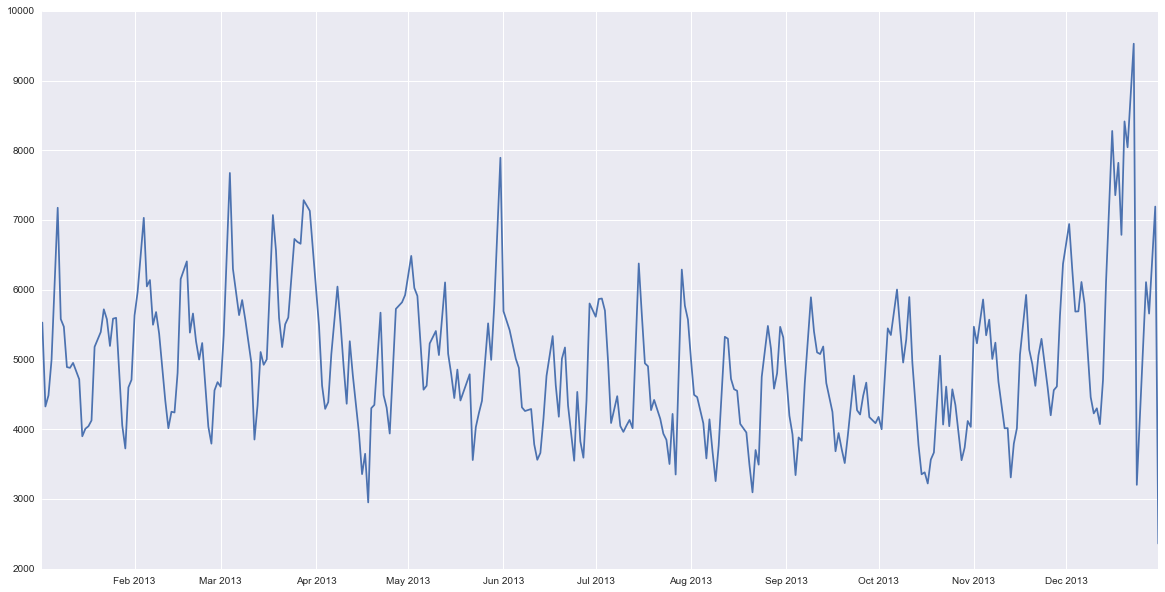

In [109]:
# criteria = dtrain[(dtrain['Store']==1) & (dtrain['Date']<datetime.date(2014,1,1))]
criteria = dtrain[(dtrain['Store']==1) & (dtrain['Sales']>0) & (dtrain['Date']<datetime.date(2014,1,1))].copy()
# criteria = dtrain[dtrain['Store']==1]
plt.figure(figsize=(20,10))
plt.plot(criteria['Date'].values,criteria['Sales'].values)
# d = criteria['Date']
# s = criteria['Sales']
# plt.plot(d,s)

In [10]:
dtrain = dtrain.set_index(dtrain['Date'])
dtest = dtest.set_index(dtest['Date'])

In [190]:
dtrain.index[0]
# dtrain.resample('W',how='sum')

Timestamp('2015-07-31 08:00:00')

In [39]:
dtrain.index.min()

Timestamp('2013-01-01 00:00:00')

In [40]:
dtrain.loc[pd.Timestamp('2013-01-01 00:00:00'):pd.Timestamp('2013-02-02 00:00:00')]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,DateDay,DateDay1,DateWeek,DateMonth,DateYear,DateDayOfYear,Set
Date,,,,,,,,,,,,,,,,


In [42]:
dtrain['Set'] = 1
dtest['Set'] = 0
### Combine train and test set
frames = [dtrain, dtest]
df = pd.concat(frames)

In [45]:
#Enhance Features

var_name = 'Date'

df[var_name + 'Day'] = pd.Index(df[var_name]).day
df[var_name + 'Week'] = pd.Index(df[var_name]).week
df[var_name + 'Month'] = pd.Index(df[var_name]).month
df[var_name + 'Year'] = pd.Index(df[var_name]).year
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear
df['DateInt'] = df['Date'].astype(np.int64)

In [55]:
dstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int32
StoreType                    1115 non-null int8
Assortment                   1115 non-null int8
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    1115 non-null float64
CompetitionOpenSinceYear     1115 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              1115 non-null float64
Promo2SinceYear              1115 non-null float64
PromoInterval                1115 non-null object
dtypes: float64(5), int32(1), int64(1), int8(2), object(1)
memory usage: 63.2+ KB


In [93]:
dstore['StoreType'] = dstore['StoreType'].astype('category').cat.codes
dstore['Assortment'] = dstore['Assortment'].astype('category').cat.codes

In [56]:
# dstore['CompetitionOpenSinceMonth'] = dstore['CompetitionOpenSinceMonth'].fillna(0)
# dstore['CompetitionOpenSinceYear'] = dstore['CompetitionOpenSinceYear'].fillna(0)
# dstore['Promo2SinceWeek'] = dstore['Promo2SinceWeek'].fillna(0)
# dstore['Promo2SinceYear'] = dstore['Promo2SinceYear'].fillna(0)
dstore['PromoInterval'] = dstore['PromoInterval'].fillna(0)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,0,0,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,2,2,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,0,0,29910.0,4.0,2015.0,0,0.0,0.0,0
5,6,0,0,310.0,12.0,2013.0,0,0.0,0.0,0
6,7,0,2,24000.0,4.0,2013.0,0,0.0,0.0,0
7,8,0,0,7520.0,10.0,2014.0,0,0.0,0.0,0
8,9,0,2,2030.0,8.0,2000.0,0,0.0,0.0,0
9,10,0,0,3160.0,9.0,2009.0,0,0.0,0.0,0


In [94]:
### Convert competition open year and month to float
def convertCompetitionOpen(dsf):
    try:
        date = '{}-{}'.format(int(dsf['CompetitionOpenSinceYear']), int(dsf['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return datetime.date(1970,1,1)

dstore['CompetitionOpenInt'] = dstore.apply(lambda dsf: convertCompetitionOpen(dsf), axis=1).astype(np.int64)

In [111]:
### Convert competition open year and month to float
def convertPromo2(dsf):
    try:
        # %w = 1 refers to Monday
        date = '{}{}1'.format(int(dsf['Promo2SinceYear']), int(dsf['Promo2SinceWeek']))
#         return pd.to_datetime(date, format='%Y%W%w')
        return pd.to_datetime(date)
    except:
        return datetime.date(1970,1,1)

dstore['Promo2SinceFloat'] = dstore.apply(lambda dsf: convertPromo2(dsf), axis=1)

In [112]:
dstore.iloc[:,7:12]

,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenInt,Promo2SinceFloat
0,NaN,NaN,NaN,1220227200000000000,1970-01-01
1,13.0,2010.0,"Jan,Apr,Jul,Oct",1193875200000000000,1970-01-01
2,14.0,2011.0,"Jan,Apr,Jul,Oct",1164931200000000000,1970-01-01
3,NaN,NaN,NaN,1251763200000000000,1970-01-01
4,NaN,NaN,NaN,1427846400000000000,1970-01-01
5,NaN,NaN,NaN,1385856000000000000,1970-01-01
6,NaN,NaN,NaN,1364774400000000000,1970-01-01
7,NaN,NaN,NaN,1412121600000000000,1970-01-01
8,NaN,NaN,NaN,965088000000000000,1970-01-01
9,NaN,NaN,NaN,1251763200000000000,1970-01-01


In [73]:
testdate

'2010131'

In [83]:
datetime.date(2016,5,23).strftime("%Y%W%w")

'2016211'